## PPO pseudocode:


<img src="https://raw.githubusercontent.com/fahimfss/RL/master/Policy%20Gradient%20Algos/files/sc2.png" alt="Drawing" style="width: 750px; float:left;"/>

Collected from [Udacity Deep Reinforcement Learning Nanodegree.](https://classroom.udacity.com/nanodegrees/nd893) 
<br>

Here I'll solve the Cartpole environment using PPO. I'll follow (not completely) the implementation details given in Udacity DRLND.

### 1. Imports

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define Policy Network

Very simple fully connected neural network.

In [2]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, action_size)
        )
        
    def forward(self, x): 
        x = self.fc(x) 
        return F.softmax(x, dim=1)   # return the probability of each action

### 3. Define Agent 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99            # discount factor
LR = 2e-4               # learning rate
SGD_epoch = 4

class Agent: 
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
         
        self.surrogate_eps = 0.1     # used for clipping
        self.surrogate_beta = 0.01    # used for creating noise
        # need to update surrogate_eps & surrogate_beta after each iteration

        self.policy = Policy(state_size, action_size).to(device) 
        self.optimizer = optim.Adam(self.policy.parameters(), lr=LR)
        
        self._init_memory()
        
    def _init_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.probs = []
        
    def step(self, state, action, reward, prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.probs.append(prob)
        
    def act(self, state):
        # returns an action and the chosen action probability
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_probs = self.policy(state).cpu()
        m = Categorical(action_probs)
        action = m.sample() 
        return action.item(), action_probs[0, action].item()
    
    def bacth_action_probs(self, states, actions):
        # returns the probabilities of performed actions in states
        
        actions_probs = self.policy(states)
        actions = actions.unsqueeze(1)
        
        # return the probs of taken actions
        ret = actions_probs.gather(1, actions).squeeze(1)
        return ret

    def learn(self):
        rewards_future = self._calc_rewards(self.rewards)

        mean = np.mean(rewards_future)
        std = np.std(rewards_future) + 1.0e-10
        rewards_normalized = (rewards_future - mean)/std
        
        states = torch.tensor(self.states, dtype=torch.float, device=device)
        actions = torch.tensor(self.actions, dtype=torch.int64, device=device)
        probs = torch.tensor(self.probs, dtype=torch.float, device=device)
        rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
        
        for i in range(SGD_epoch):       
            self.optimizer.zero_grad()
            L = -self.clipped_surrogate(states, actions, rewards, probs)
            L.backward()
            self.optimizer.step()
            del L
            
        self.surrogate_eps *= 0.999    
        self.surrogate_beta *= 0.995   
        
        self._init_memory()
    
    def clipped_surrogate(self, states, actions, rewards, probs):        
        new_probs = self.bacth_action_probs(states, actions)
        ratio = new_probs/probs

        clip = torch.clamp(ratio, 1-self.surrogate_eps, 1+self.surrogate_eps)
        clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

        entropy = -(new_probs*torch.log(probs+1.e-10)+ \
            (1.0-new_probs)*torch.log(1.0-probs+1.e-10))
        
        return torch.mean(clipped_surrogate + self.surrogate_beta*entropy)
        
    def _calc_rewards(self, rewards):
        # returns the discounted rewards for each timesteps
        ret = []
        c_reward = 0.0
        for reward in reversed(rewards):
            c_reward *= GAMMA
            c_reward += reward
            ret.append(c_reward)
        return list(reversed(ret))

### 4. PPO

In [4]:
env = gym.make('CartPole-v0')   

state_size = 4
action_size = 2

print('state size:', state_size)
print('action size:', action_size)

agent = Agent(state_size, action_size)

def PPO(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):        
        state = env.reset()
        rewards = 0.0
        for t in range(max_t):
            action, prob = agent.act(state)
            n_state, reward, done, _ = env.step(action)
            rewards += reward
            agent.step(state, action, reward, prob)
            if done:
                agent.learn()
                break
            state = n_state
        scores_deque.append(rewards)
        scores.append(rewards)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = PPO()
    

state size: 4
action size: 2
Episode 100	Average Score: 36.28
Episode 200	Average Score: 132.69
Episode 300	Average Score: 163.83
Episode 400	Average Score: 188.60
Episode 500	Average Score: 194.42
Environment solved in 415 episodes!	Average Score: 195.67


### 5. Rewards plot

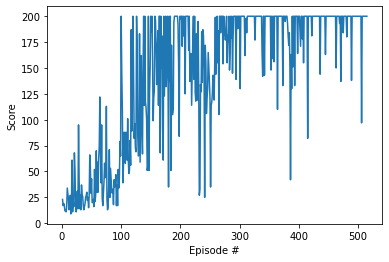

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Run the trained agent

In [6]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(5000):
    action, _ = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

### 7. Remarks
- PPO needs a lot of episodes to train (specially for harder env).
- Run to run results vary a lot.
- Hyper-parameters like learning rate, surrogate_eps tuning matters a lot.